# Predicting Financial Fraud of Firms
## Introduction

Firms report financial statements for every quarter and annual period. These statements are first reported internally by the organization, which in turn must be audited by accredited auditing firms to verify that the reports are accurate. Firms may be incentivized to create fraud within their reports for financial benefits such as taxation and value inflation. Thus, the paper and data report the findings when an external auditing firm runs various methods such as F Measures, Type l-ll errors, and Correlation Coefficients to detect fraud.

Our project will try to determine if our selected variables can form a model to accurately predict whether or not a firm is fraudulent. In other words, the project will utilize KNN classification to classify firms as fraudulent or non-fraudulent based on given variables.

The dataset that will be used to answer this question is Audit Data. Audit Data contains risk factor classifications and methods used by the external auditing firm. Specifically, the data contains reports from 777 firms from 46 different listings and 14 different sector scores. Some examples of the different risk factors include discrepancy values found in auditing reports, historical risk values, and average historical loss suffered by firms in the last 10 years.


## Wrangling and Exploring the Data

First, we load the libraries that we need, which are tidyverse, tidymodels, repr, and GGally.

In [61]:
library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)

Now we want to download the data from the url. Since it is in .zip format, we have to download it before unzipping and then using read_csv(). The file "audit_risk.csv" is the one with the data that we want to use to create our classification.

In [62]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00475/audit_data.zip"
download.file(url, "audit_data.zip")
unzip("audit_data.zip")

audit_risk_data_main <- read_csv("audit_data/audit_risk.csv")
head(audit_risk_data_main, 3) ### show the first 3 rows of the data to see if it is tidy.

Warning message:
“Duplicated column names deduplicated: 'Score_B' => 'Score_B_1' [11]”
Parsed with column specification:
cols(
  .default = col_double(),
  LOCATION_ID = col_character()
)

See spec(...) for full column specifications.



Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5,⋯,0.4,0,0.2,0,2.4,8.574,0.4,0.5,1.7148,1
3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5,⋯,0.4,0,0.2,0,2.0,2.554,0.4,0.5,0.5108,0
3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5,⋯,0.4,0,0.2,0,2.0,1.548,0.4,0.5,0.3096,0


We are determining risk through classification, so the column type needs to be converted to a factor.

The data appears to be tidy. Each column is one variable, each row is one observation, and each cell has exactly one value. Therefore, we will not need to wrangle the data.

In [63]:
audit_risk_data_main <- mutate(audit_risk_data_main, Risk = as_factor(Risk))
head(audit_risk_data_main, 3)

Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5,⋯,0.4,0,0.2,0,2.4,8.574,0.4,0.5,1.7148,1
3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5,⋯,0.4,0,0.2,0,2.0,2.554,0.4,0.5,0.5108,0
3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5,⋯,0.4,0,0.2,0,2.0,1.548,0.4,0.5,0.3096,0


Now that the main table has been loaded, we can separate it into the training and testing data sets. We set the seed so the split is the same everytime and then use initial_split to perform the split.

In [64]:
### SET THE SEED
set.seed(18)
### DO NOT CHANGE

audit_risk_data_split <- initial_split(audit_risk_data_main, prop = 2/3, strata = Risk)
audit_risk_data_training <- training(audit_risk_data_split)
audit_risk_data_testing <- testing(audit_risk_data_split)

## Visualizing the Training Data

We should examine the data to see possible trends. We can get rid of the columns that we will not be using and then calculate the mean, median, standard deviation, min, and max to get a general sense of the numbers.

In [65]:
audit_risk_data_training_predictors <- select(audit_risk_data_training, History, TOTAL, Money_Value) ### Select the predictors only

### Now we can calculate the mean, median, min, and max and combine them all into one tibble.

audit_risk_data_training_mean <- audit_risk_data_training_predictors %>%
map_df(mean, na.rm = TRUE) %>%
mutate(Stat = "mean")

audit_risk_data_training_max <- audit_risk_data_training_predictors %>%
map_df(max, na.rm = TRUE) %>%
mutate(Stat = "max")

audit_risk_data_training_min <- audit_risk_data_training_predictors %>%
map_df(min, na.rm = TRUE) %>%
mutate(Stat = "min")

audit_risk_data_training_median <- audit_risk_data_training_predictors %>%
map_df(median, na.rm = TRUE) %>%
mutate(Stat = "median")

audit_risk_data_training_stdev <- audit_risk_data_training_predictors %>%
map_df(sd, na.rm = TRUE) %>%
mutate(Stat = "stdev")

audit_risk_data_training_stats <- bind_rows(audit_risk_data_training_max, audit_risk_data_training_mean,
                                            audit_risk_data_training_min, audit_risk_data_training_median,
                                            audit_risk_data_training_stdev)

audit_risk_data_training_stats

History,TOTAL,Money_Value,Stat
<dbl>,<dbl>,<dbl>,<chr>
9.0000000,1268.91000,935.03000,max
0.1138996,13.88798,17.35457,mean
0.0000000,0.00000,0.00000,min
0.0000000,1.35500,0.13000,median
0.5567937,60.19784,80.31088,stdev


### Analyzing the table

In our table, the max values are very large in comparison to the mean and median.

When comparing the mean to the median, we notice that they are quite far apart. This could indicate that there are not many fraudulent bodies but there are some at the top with very large Money_Value and TOTAL values that raise the mean but do not affect the median by much.

The min indicates that every value can be exactly zero.

<strong>In addition to calculating those stats, we should see how many observations have risk factors of 0 or 1, as well as the total observations.</strong>

In [66]:
audit_risk_data_count <- audit_risk_data_training %>%
group_by(Risk) %>%
summarize(n = n())

audit_risk_data_count

`summarise()` ungrouping output (override with `.groups` argument)



Risk,n
<fct>,<int>
0,314
1,204


There seems to about an even split, which is good because it will provide us with enough samples of each to accurately predict the Risk. The total number of observations in our training data is 518. This should be sufficient to be accurate.

### Creating a Plot

Based on the stats of the previous table, we could plot TOTAL against Money_Value to see if they are correlated. When inspecting the mean/median/stdev table, they appear to have some degree of correlation. It is less clear if History has a correlation with them, but we can plot all three of our predictor variables against each other in a ggpairs matrix in order to examine any possible correlation. Also, we can check the distributions of each variable in the ggpairs plot.

Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removing 1 row that contained a missing value”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removing 1 row that contained a missing value”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing non-finite values (stat_density).”


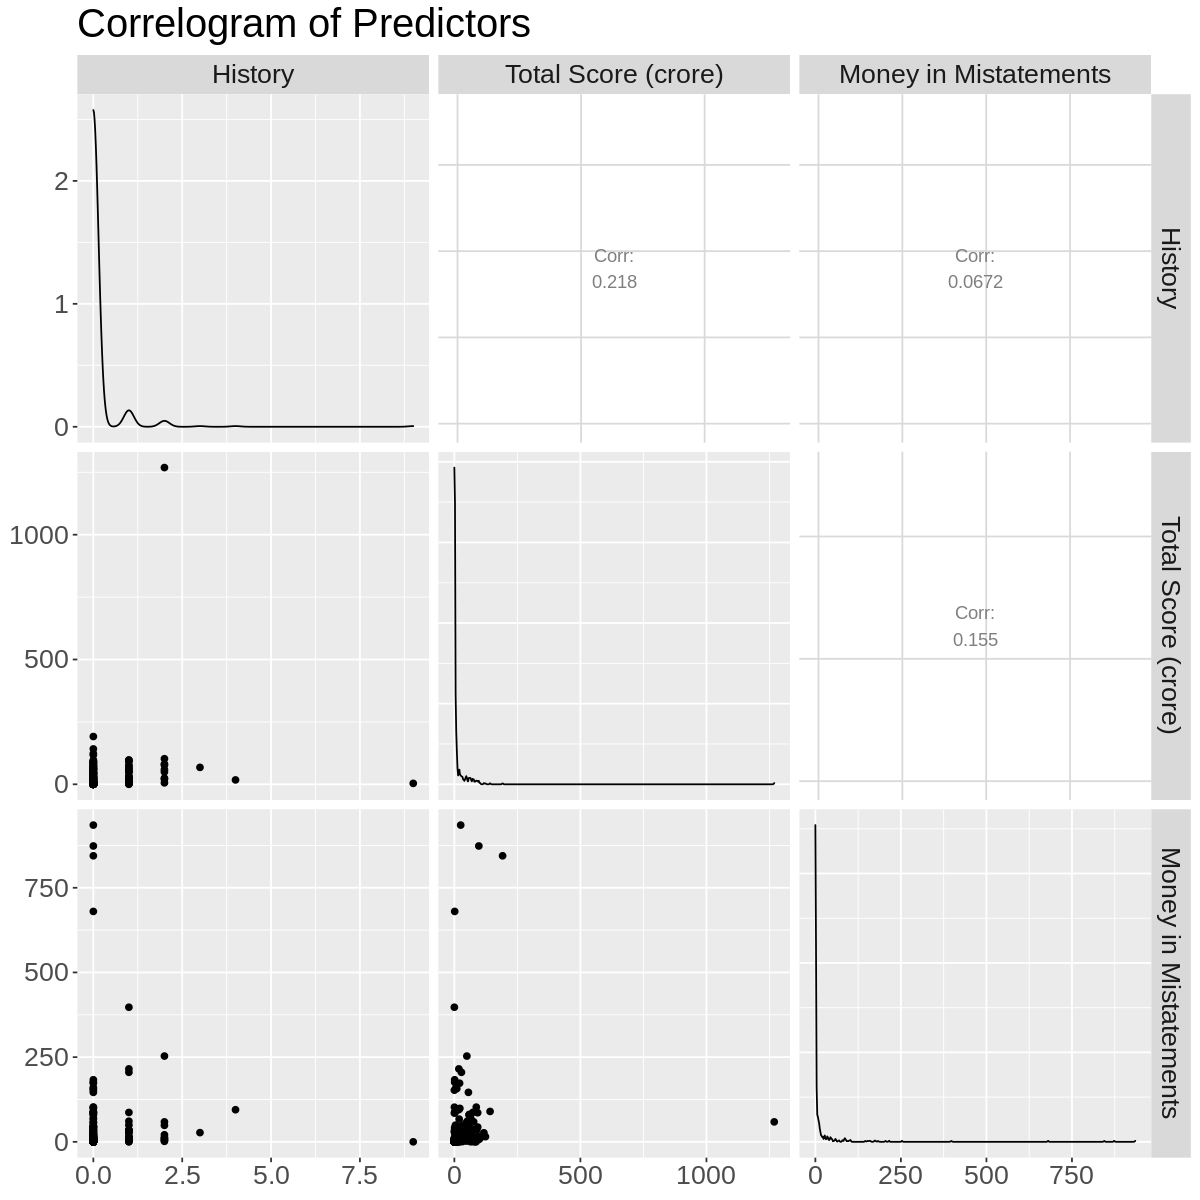

In [67]:
options(repr.plot.width=10, repr.plot.height=10)

audit_risk_data_pairs <- audit_risk_data_training_predictors %>%
ggpairs(columnLabels = c("History", "Total Score (crore)", "Money in Mistatements")) +
theme(text = element_text(size = 20)) +
ggtitle("Correlogram of Predictors")

audit_risk_data_pairs

First, when we look at the correlation values, two have a very weak positive correlation. The correlation between History and TOTAL is the strongest out of the three, but it is still rather weak. History and Money_Value have almost no correlation at all.

When looking at the distributions, they all have very high peaks near 0 and then quickly drop off as the bin numbers increase. This could be an issue if there are not enough neighbors with higher magnitude of predictor variable values to look at during knn classification. However, the ratio of Risk = 0 to Risk = 1 is about 1:1 so there should be enough to do a proper knn classification.

The scatterplots are really hard to read. The History-Total plot and History-Money plot have odd pillars which could indicate that History score is quantized. The Score-Money plot appears to have one outlier which makes the plot extremely difficult to read. When looking at the plots it doesn't appear that any strong correlation can be interpreted, which matches our observations about the Pearson coeff.

## Methods

### Variables

1. History (Average historical loss suffered by the firm in the last 10 years)
The history variable seems like a relevant variable to predict fraud since we predict there must be a correlation between the tendency to commit fraud and the financial health of a firm. Meaning that underperforming firms must be more desperate and inclined for fraudulent reporting. 
2. Total (Total amount of discrepancy found in other reports Rs (in crore))
The total discrepancy is an obvious variable which we intend to use. Since high discrepancies indicate inaccuracies, this must naturally lead to more fraudulent reports.
3. Money Value (Amount of money involved in misstatements in the past audit)
The last variable, money value, is also closely linked to the Total variable. We assume that higher amounts of misstatements suggest suspicious activity from a firm. Hence, they will be more likely to commit fraudulent activity.

### Method of Analysis

We will use the three variables mentioned above for a k-nearest neighbors model to classify whether or not a firm is considered fraudulent. This will be done by training the model using training data in a 5 fold cross-validation fit and also finding the optimal value of k by using a tuning method. Then the model will be applied to testing data and the accuracy of the model will be evaluated.

Our results will be visualized by displaying the accuracy of our model in a table and also producing a confusion matrix of the predicted Risk vs the actual Risk.

## Expected Outcomes and Significance

From the above diagrams, we expect that our three variables will have high accuracy in predicting the fraudulent activity of the firms. With the ongoing growth of financial fraud cases, finding the key indicators of fraud can help maintain and improve the quality of audit fieldwork. It would be worth further investigating why these observations have different strengths of correlation to the classification results. This would ensure a more applicable model going forward and allow firms to become more transparent to consumers.